In [83]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [2]:
# Load dataset
with open('names.txt') as f:
    words = f.readlines()
words = list(map(str.strip, words))
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [3]:
# Get mapping between characters and numbers
chars = sorted(list(set(''.join(words) + '.')))
stoi = dict(list(zip(chars, range(len(chars)))))
itos = {v:k for k,v in stoi.items()}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [4]:
# Generate dataset

BLOCK_SIZE = 3

def generate_dataset(words):
    X = []
    y = []

    for word in words:
        block = [0] * BLOCK_SIZE
        for c in word + '.':
            X.append(block)
            y.append(stoi[c])
            block = block[1:] + [stoi[c]]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
    
X, y = generate_dataset(words)

In [12]:
# Init network

N_EMBEDDINGS = 5
HIDDEN_NEURONS = 200
C = torch.randn((27, N_EMBEDDINGS), requires_grad=True)
W1 = torch.randn((N_EMBEDDINGS * BLOCK_SIZE, HIDDEN_NEURONS), requires_grad=True)
b1 = torch.randn(HIDDEN_NEURONS, requires_grad=True)
W2 = torch.randn((HIDDEN_NEURONS, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters)

8762

In [13]:
def forward(X):
    embeddings = C[X]
    x = embeddings.view(-1, N_EMBEDDINGS * BLOCK_SIZE)
    x = x @ W1 + b1
    x = torch.tanh(x)
    x = x @ W2 + b2
    return x

In [17]:
# Training
lossi = []
for epoch in range(100000):
    batch = torch.randint(0, X.shape[0], (32,))
    
    pred = forward(X[batch])
    loss = F.cross_entropy(pred, y[batch])
    lossi.append(loss.item())
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data -= 0.05 * p.grad
    
print(np.mean(lossi))

2.2153566851711273


In [114]:
# Predict with model
generator = torch.Generator().manual_seed(1337)

# Generate names from bigram distribution
for _ in range(10):
    out = []
    block = [0] * BLOCK_SIZE
    while True:
        pred = forward(block)
        #probs = counts / counts.sum(1, keepdims=True)
        probs = F.softmax(pred, dim=1)
        s = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
        out.append(s)
        block = block[1:] + [s]
        if s == 0:
            break
    print(''.join(itos[c] for c in out))

mylieke.
rada.
erackanolando.
yusamailem.
karlymandrah.
parlif.
meilae.
ayy.
saiora.
jaylianyyah.


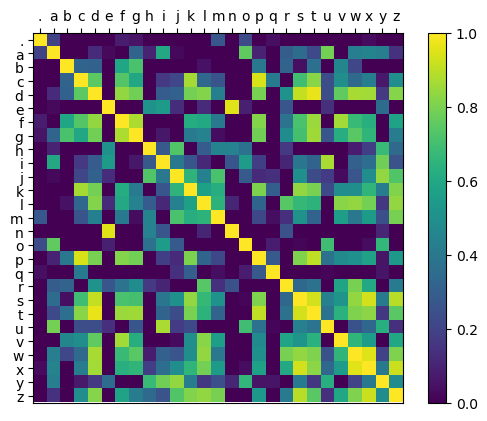

In [113]:
similarities = np.zeros((27, 27))
for c1 in range(27):
    for c2 in range(27):
        similarities[c1, c2] = F.relu(F.cosine_similarity(C[c1], C[c2], dim=0)).item()
        
fig, ax = plt.subplots()

plt.imshow(similarities)

ax.xaxis.tick_top()
ax.set_xticks(range(len(itos)))
ax.set_xticklabels(list(itos.values()))

ax.set_yticks(range(len(itos)))
ax.set_yticklabels(list(itos.values()))

fig.colorbar(cm.ScalarMappable(), ax=ax)

plt.show()